# Performance comparison

This notebook compares the performance of `cuDF` and `pandas`. The comparisons performed are on identical data sizes. This notebook primarily showcases the factor
of speedups users can have when the similar `pandas` APIs are run on GPUs using `cudf`.

The hardware details used to run these performance comparisons are at the end of this page.

**Note**: This notebook is written to measure performance on NVIDIA GPUs with large memory. If running on hardware with lower memory, please consider lowering the `num_rows` values. Performance results may vary by data size, as well as the CPU and GPU used.

In [63]:
import os
import time
import timeit
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cudf

In [64]:
np.random.seed(0)

## Concat, count & joins performance

In [ ]:
num_rows = 30_000_000
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

In [ ]:
gdf = cudf.from_pandas(pdf)
gdf

In [65]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [ ]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=30
)

In [ ]:
pdf = pdf.head(10_000_000)
gdf = gdf.head(10_000_000)

In [ ]:
pandas_concat = timeit.timeit(lambda: pd.concat([pdf, pdf, pdf]), number=30)

In [ ]:
cudf_concat = timeit.timeit(lambda: cudf.concat([gdf, gdf, gdf]), number=30)

In [ ]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=30,
)

In [ ]:
num_rows = 1_000_000
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [ ]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=30
)

In [ ]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)

In [ ]:
performance_df

In [ ]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 400),
    rot=0,
    xlabel="Operation",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

In [ ]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf
import gc

_ = gc.collect()

## Strings Performance

In [66]:
num_rows = 3_000_000
pd_series = pd.Series(
    np.random.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=num_rows
    )
)

In [67]:
gd_series = cudf.from_pandas(pd_series)

In [68]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=20
)

In [69]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.contains(r"[0-9][a-z]"), number=20
)

In [70]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=20
)

In [71]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)

In [72]:
performance_df

,cudf speedup vs. pandas
upper,424.081710
contains,332.456783
isalpha,745.782328


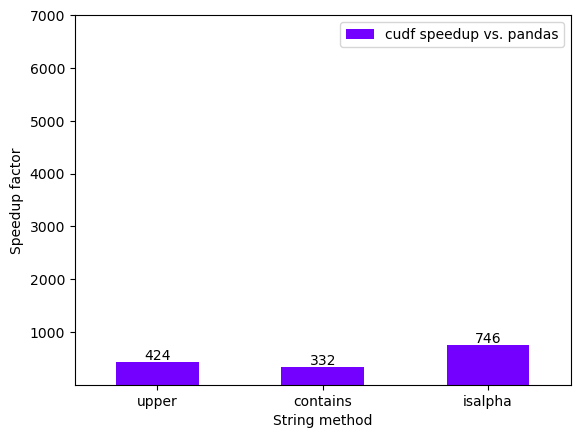

In [73]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 7000),
    rot=0,
    xlabel="String method",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## User-defined function (UDF) performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of first run and average of next few runs are compared separately.

In [ ]:
num_rows = 10_000_000
pdf_age = pd.DataFrame(
    {
        "age": np.random.randint(0, 100, num_rows),
    }
)
pdf_age

In [ ]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

In [ ]:
def age_udf(row):
    if row["age"] < 18:
        return 0
    elif 18 <= row["age"] < 20:
        return 1
    elif 20 <= row["age"] < 30:
        return 2
    elif 30 <= row["age"] < 40:
        return 3
    elif 40 <= row["age"] < 50:
        return 4
    elif 50 <= row["age"] < 60:
        return 5
    elif 60 <= row["age"] < 70:
        return 6
    else:
        return 7

In [ ]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1
)

In [ ]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [ ]:
pd_series = pd.Series(
    np.random.choice(["ABC", "abc", "hello world", "AI"], size=10_000_000),
    name="strings",
)
pd_series

In [ ]:
gd_series = cudf.from_pandas(pd_series)
gd_series

In [ ]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1
)

In [ ]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their first runs.

In [ ]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 550),
    rot=0,
    xlabel="UDF Kind",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## User-defined function (UDF) performance (without JIT overhead)

In [ ]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=10
)

In [ ]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=10
)

In [ ]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their consequent runs. In this case the speedup is massive because of no JIT overhead present.

In [ ]:
ax = performance_df.plot.bar(
    color="#7400ff",
    ylim=(1, 100000),
    rot=0,
    xlabel="UDF Kind",
    ylabel="Speedup factor",
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

## UDF Performance in GroupBy

In [ ]:
num_rows = 10_000_000
pdf = pd.DataFrame()
pdf["key"] = np.random.randint(0, 2, num_rows)
pdf["val"] = np.random.randint(0, 7, num_rows)


def custom_formula_udf(df):
    df["out"] = df["key"] * df["val"] - 10
    return df


gdf = cudf.from_pandas(pdf)

In [ ]:
pandas_udf_groupby, cudf_udf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
    number=10,
)

In [ ]:
performance_df = pd.DataFrame(
    {"cudf speedup vs. pandas": [pandas_udf_groupby / cudf_udf_groupby]},
    index=["Grouped UDF"],
)
performance_df

In [ ]:
ax = performance_df.plot.bar(
    color="#7400ff", ylim=(1, 500), rot=0, ylabel="Speedup factor"
)
ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

# System Configuration

## CPU Configuration

In [ ]:
!lscpu

## GPU Configuration

In [ ]:
!nvidia-smi